## Atmospheric River Detection QC  
  
>This notebook performs some basic QC tasks on the AR detection outputs. Select AR event attributes are examined through time, and AR event attribute min/mean/max values, distributions, and pairwise relationships are also explored.  
>**Note:** In this notebook the term "AR event" refers only to landfalling AR multipolygons aggregated over adjacent timesteps.  

>Run this notebook after executing the `download.py`  ->  `compute_ivt.py`  ->  `ar_detection.py` pipeline as described in the [repo](https://github.com/ua-snap/ar_avalanche) `README.md`

#### Setup:

In [119]:
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, LineString, shape
import math
import numpy as np

from config import shp_fp, csv_fp, ak_shp, landfall_shp, landfall_csv, landfall_events_shp, landfall_events_csv

In [124]:
#import raw AR shapefile/csv and convert time to datetime
raw = gpd.read_file(shp_fp)
raw['time'] = pd.to_datetime(raw['time'])
raw_ = pd.read_csv(csv_fp)

#read AR landfall shapefile/csv and convert time to datetime
landfall = gpd.read_file(landfall_shp)
landfall['time'] = pd.to_datetime(landfall['time'])
landfall_ = pd.read_csv(landfall_csv)

#read AR events shapefile/csv and convert start/end to datetime
events = gpd.read_file(landfall_events_shp)
events['start'] = pd.to_datetime(events['start'])
events['end'] = pd.to_datetime(events['end'])
events_ = pd.read_csv(landfall_events_csv)

#### Check attributes:    

View column description CSV for each output dataset, and check that the columns in the shapefile output and CSV output are identical.

In [98]:
#helper function to view & check attributes
def attr_check(shp, tbl):
    pd.set_option('display.max_colwidth', None)
    display(tbl)
    pd.set_option('display.max_colwidth', 150)

    missing = []
    for a in shp.columns.values.tolist():
        if a not in tbl.shp_col.values.tolist():
            missing.append(a)
    
    if len(missing) == 0:
        print("Columns in shapefile and table are identical.")
    else:
        print("There are some missing columns:")
        print(missing)

In [99]:
attr_check(raw, raw_)

,shp_col,desc
0,time,timestep of AR
1,label,original candidate region label of timestep AR
2,geometry,geometry string for AR polygon
3,ratio,length to width ratio of timestep AR
4,length,length (km) of timestep AR
5,orient,orientation of timestep AR
6,poleward,poleward strength of timestep AR
7,dir_coher,directional coherence (%) of timestep AR
8,mean_dir,mean IVT direction of timestep AR
9,tot_str,sum of IVT within timestep AR


Columns in shapefile and table are identical.


In [100]:
attr_check(landfall, landfall_)

,shp_col,desc
0,time,timestep of AR
1,label,original candidate region label of timestep AR
2,geometry,geometry string for AR polygon
3,ratio,length to width ratio of timestep AR
4,length,length (km) of timestep AR
5,orient,orientation of timestep AR
6,poleward,poleward strength of timestep AR
7,dir_coher,directional coherence (%) of timestep AR
8,mean_dir,mean IVT direction of timestep AR
9,tot_str,sum of IVT within timestep AR


Columns in shapefile and table are identical.


In [125]:
attr_check(events, events_)

,shp_col,desc
0,event_id,unique AR event ID
1,geometry,geometry string for AR event polygons
2,start,first timestep of AR event
3,end,last timestep of AR event
4,sumtot_str,sum of IVT across all timestep ARs in event
5,sumrel_str,sum of relative IVT (sum IVT/area) across all timestep ARs in event
6,ratio_m,mean length to width ratio across all timestep ARs in event
7,len_km_m,mean length (km) across all timestep ARs in event
8,orient_m,mean orientation across all timestep ARs in event
9,poleward_m,mean poleward strength across all timestep ARs in event


Columns in shapefile and table are identical.


#### Counts and Ranges:

View counts of AR detection outputs, and attribute ranges of AR events.

In [102]:
print("There were " + str(len(raw)) + " individual timestep ARs detected across the entire spatial and temporal domain.")
print("Of these, " + str(len(landfall)) + " ARs detected intersected the Alaska polygon boundary.")
print("Of these, " + str(len(events)) + " possible AR events were aggregated using adjacent timesteps and overlapping geometry.")
print("\n")
print("On average, we detected " + str(len(events)/30) + " possible AR events per year.")

There were 19146 individual timestep ARs detected across the entire spatial and temporal domain.
Of these, 8293 ARs detected intersected the Alaska polygon boundary.
Of these, 1802 possible AR events were aggregated using adjacent timesteps and overlapping geometry.


On average, we detected 60.06666666666667 possible AR events per year.


In [128]:
gdf = events

Text(0.5, 0.95, 'AR event properties: min, mean, max (1992-2022)')

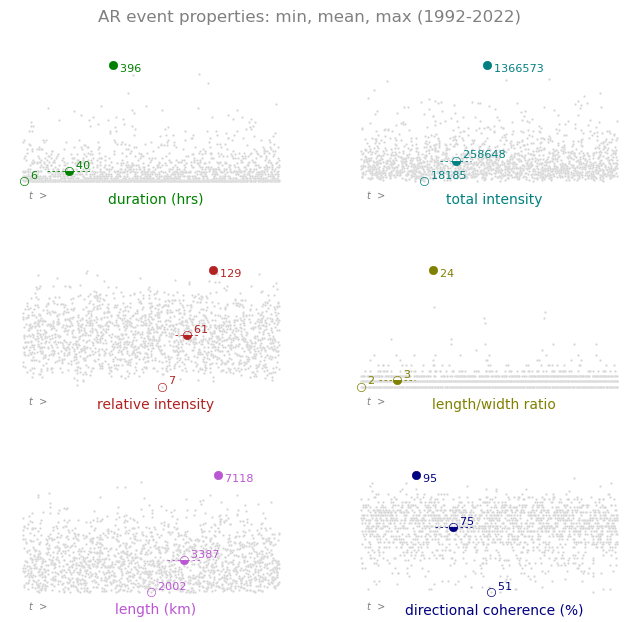

In [104]:
#subset attributes, including time for x-axis
sub = gdf[['start', 'dur_hrs', 'tintensity', 'rintensity', 'ratio_m', 'len_km_m', 'dircoher_m']]
titles = ['duration (hrs)', 'total intensity', 'relative intensity', 'length/width ratio', 'length (km)', 'directional coherence (%)']

#setup plot and axes
fig, axes = plt.subplots(int(len(sub.drop(columns='start').columns)/2), 2, sharex=False, figsize=(8, 7))
plt.subplots_adjust(hspace = 0.6)
sns.set_style("white")
sns.despine(fig=fig, ax=axes, top=True, right=True, left=True, bottom=True, offset=None, trim=False)

#define color pairs....must be the same # of pairs as # of non-time attributes
colors = ['green', 'teal', 'firebrick', 'olive', 'mediumorchid', 'navy']
#fontsize for attr text
f = 8

for attr, ax, t, c in zip(sub.drop(columns='start').columns.values.tolist(), fig.axes, titles, colors):
    #get stats
    a_min, a_mean, a_max = sub[attr].values.min(), sub[attr].values.mean(), sub[attr].values.max()
    #set time values for each stat
    a_min_idx, a_max_idx = sub[attr].idxmin(), sub[attr].idxmax()
    min_t, max_t = sub['start'].iloc[sub[attr].idxmin()], sub['start'].iloc[sub[attr].idxmax()]
    mean_t = min_t + (max_t - min_t) / 2
    #set time values for mean line extension; use 25% of distance between min_t and max_t
    mean_t_low = min_t + (max_t - min_t) / 4
    mean_t_high = max_t - (max_t - min_t) / 4
    #plot data line and mean line extension
    #sns.lineplot(ax=axes[ax], data=sub, x='start', y=attr, color='lightgray', linewidth=.6)
    sns.scatterplot(ax=ax, data=sub, x='start', y=attr, color='lightgray', s=2.75)

    sns.lineplot(ax=ax, x=[mean_t_low, mean_t, mean_t_high], y=[a_mean, a_mean, a_mean], color=c, linewidth=.6, linestyle=(0, (3,3)))
    #plot points
    ax.plot(min_t, a_min, marker='o', fillstyle='none', markeredgewidth= .5, c=c)
    ax.plot(max_t, a_max, marker='o', fillstyle='full', markeredgewidth= .5, c=c)
    ax.plot(mean_t, a_mean, marker='o', fillstyle='bottom', markeredgewidth= .5, c=c)
    #define nudge distance for point labels (divides the y-axis into 50 parts)
    nudge = (a_max - a_min)/50
    #add point labels
    ax.text(x = min_t, y = a_min + nudge, s = str("  " + str(int(a_min))), color = c, fontsize=f)
    ax.text(x = max_t, y = a_max - nudge*3, s = str("  " + str(int(a_max))), color = c, fontsize=f)
    ax.text(x = mean_t, y = a_mean + nudge, s = str("  " + str(int(a_mean))), color = c, fontsize=f)
    #adjust axis labels
    ax.set_ylabel(t, rotation=0, labelpad=-105, color=c, fontsize=f+2, y=-0.15)
    ax.set_xlabel('t  >', rotation=0, labelpad=3, color='gray', fontsize=f-1, style='italic', x=0.1)
#remove axes ticks and add title    
plt.setp(axes, yticks=[], xticks=[])
fig.suptitle('AR event properties: min, mean, max (1992-2022)', color='gray', fontsize=f+4, y=.95)

#### AR Property Distributions and Pairwise Relationships

Plots from the upper-left to lower-right diagonal show univariate distributions for each AR property (ie, a histogram with estimated density curve). All other plots show pairwise relationships between AR properties, with plots on the lower left of the figure showing kernel density estimation and plots on the upper right showing a scatterplot of all observations.

Text(0.5, 1.01, 'Pairplot of AR Event Properties')

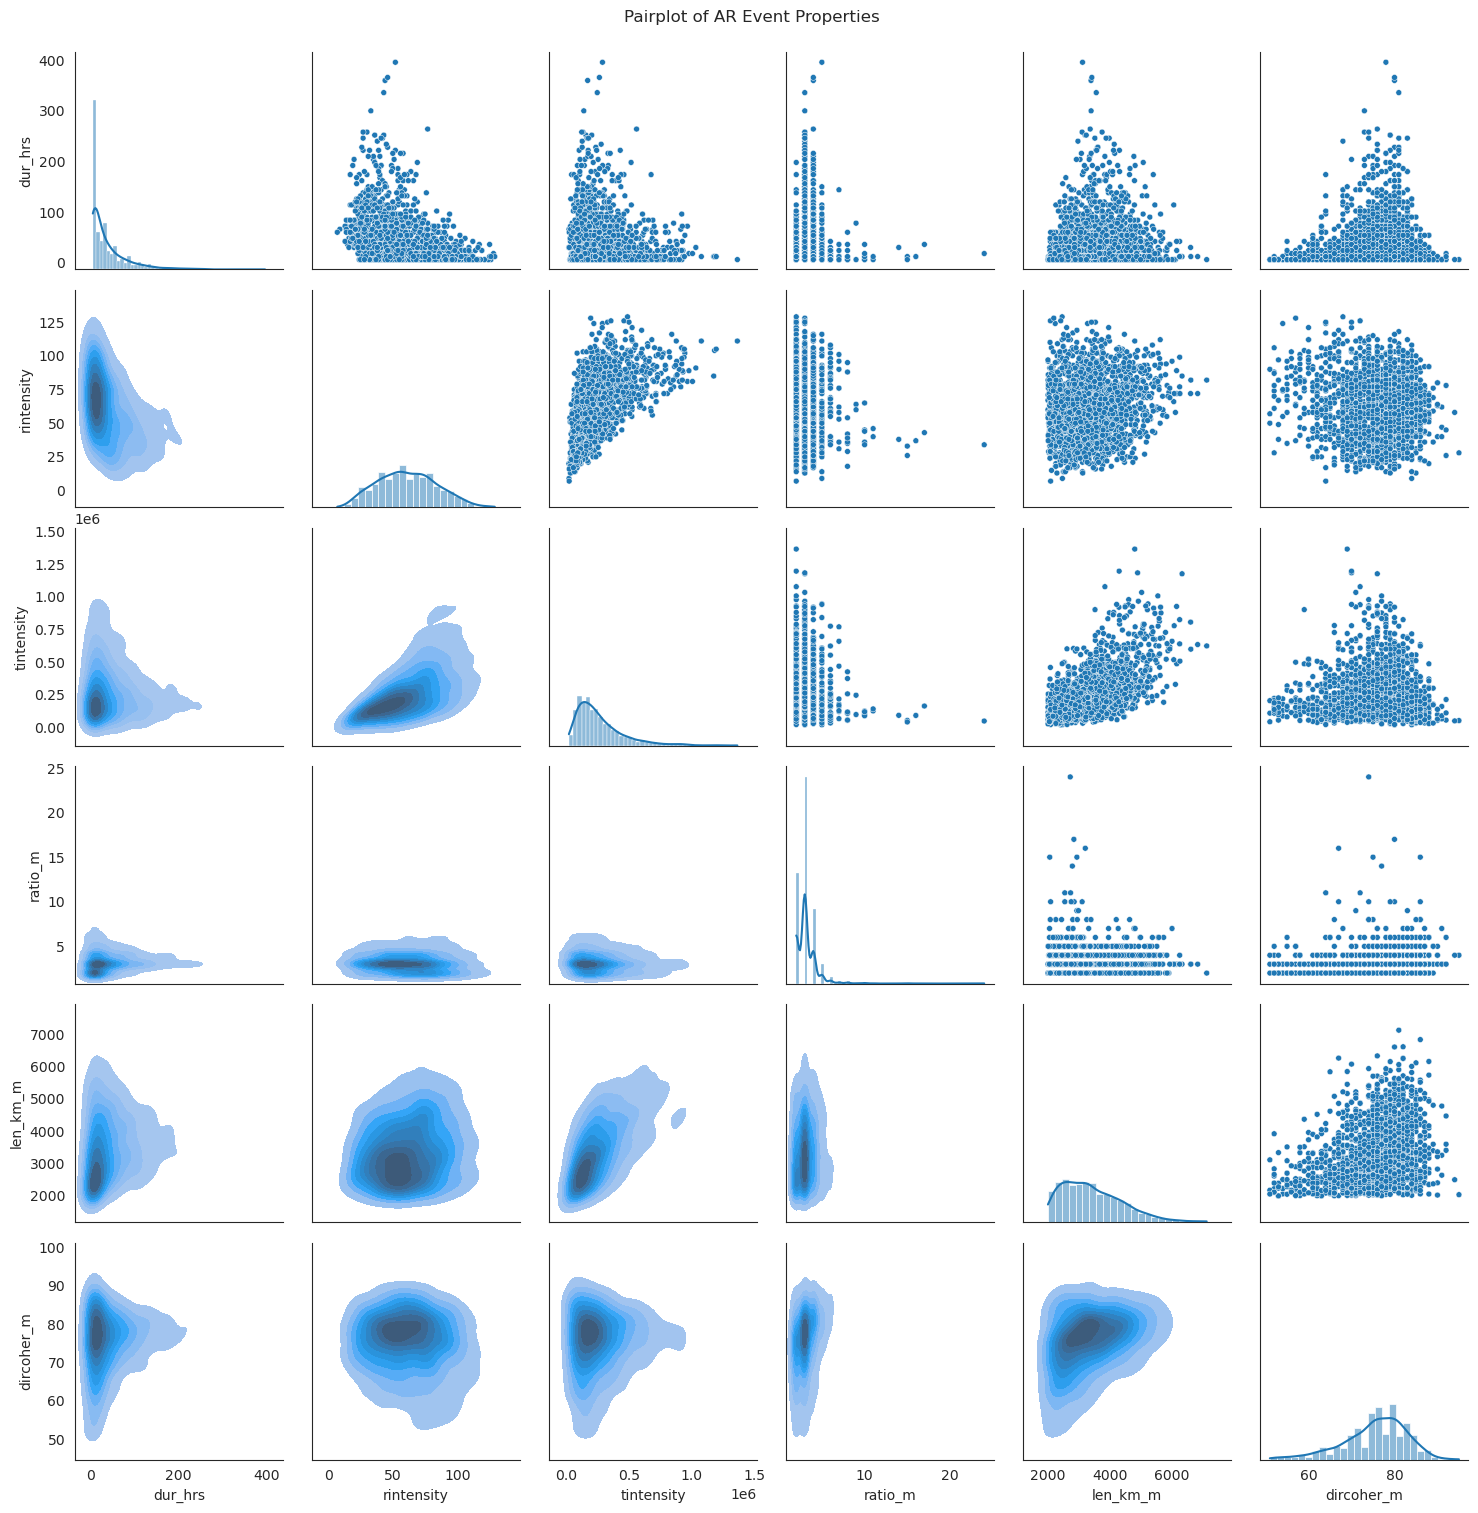

In [105]:
sub = gdf[['dur_hrs', 'rintensity', 'tintensity', 'ratio_m', 'len_km_m', 'dircoher_m']]
sns.set_style("white")

g = sns.PairGrid(sub)
g.map_upper(sns.scatterplot, size=0.1)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

g.fig.suptitle('Pairplot of AR Event Properties', y=1.01)

#### Heatmaps: Event Timing and Extremes

View select AR event properties by month and year. Do the extremes of the heat map match the timing of other atmospheric phenomena (ie el Nino/la Nina, PDO, etc)?

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0, 0.5, '1'),
  Text(0, 1.5, '2'),
  Text(0, 2.5, '3'),
  Text(0, 3.5, '4'),
  Text(0, 4.5, '5'),
  Text(0, 5.5, '6'),
  Text(0, 6.5, '7'),
  Text(0, 7.5, '8'),
  Text(0, 8.5, '9'),
  Text(0, 9.5, '10'),
  Text(0, 10.5, '11'),
  Text(0, 11.5, '12')])

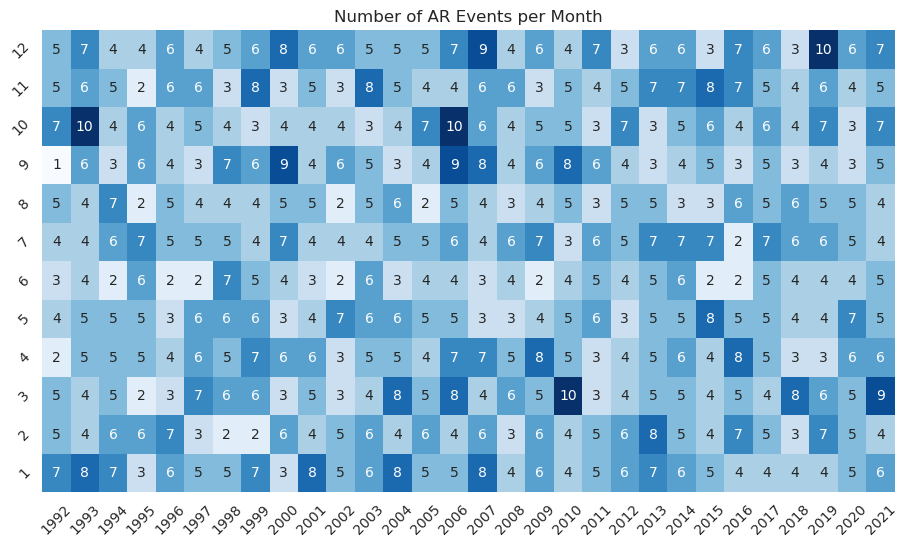

In [106]:
gdf["Year"] = gdf.start.apply(lambda x: x.year)
gdf["Month"] = gdf.end.apply(lambda x: x.month)
pt = gdf.pivot_table(index="Month",columns="Year",values="event_id", aggfunc="count").fillna(0)

fig, ax = plt.subplots(figsize=(11, 6))
sns.heatmap(pt, annot=True, ax=ax, cmap='Blues', cbar=False)

ax.invert_yaxis()
ax.set_title('Number of AR Events per Month')
ax.set(xlabel=None, ylabel=None)
plt.xticks(rotation=45)
plt.yticks(rotation=45)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0, 0.5, '1'),
  Text(0, 1.5, '2'),
  Text(0, 2.5, '3'),
  Text(0, 3.5, '4'),
  Text(0, 4.5, '5'),
  Text(0, 5.5, '6'),
  Text(0, 6.5, '7'),
  Text(0, 7.5, '8'),
  Text(0, 8.5, '9'),
  Text(0, 9.5, '10'),
  Text(0, 10.5, '11'),
  Text(0, 11.5, '12')])

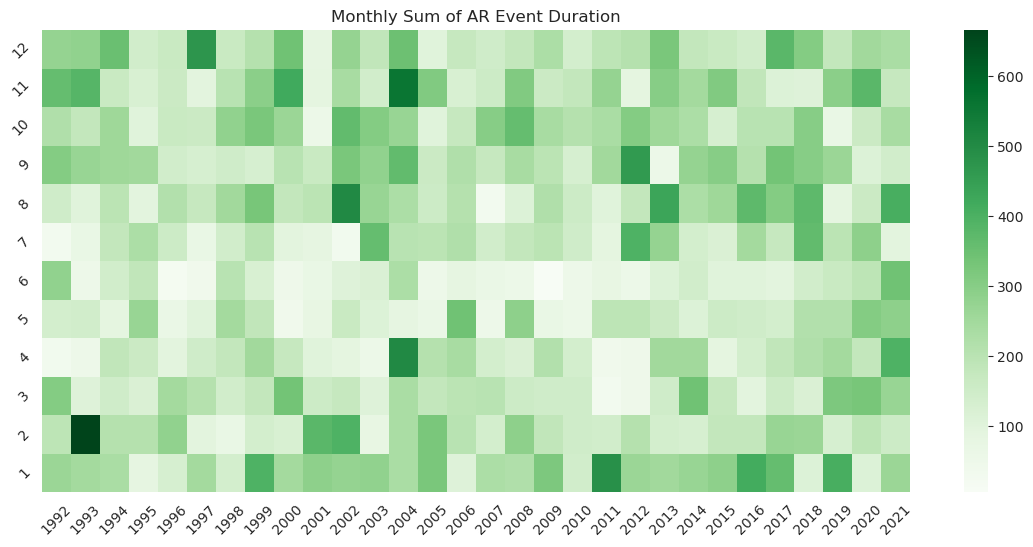

In [107]:
gdf["Year"] = gdf.start.apply(lambda x: x.year)
gdf["Month"] = gdf.start.apply(lambda x: x.month)
pt = gdf.pivot_table(index="Month",columns="Year",values="dur_hrs", aggfunc="sum").fillna(0)

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(pt, annot=False, ax=ax, cmap='Greens')

ax.invert_yaxis()
ax.set_title('Monthly Sum of AR Event Duration')
ax.set(xlabel=None, ylabel=None)
plt.xticks(rotation=45)
plt.yticks(rotation=45)

In [108]:
gdf['rintensity_dev'] = gdf['rintensity'] - gdf['rintensity'].mean()
#gdf['rintensity_dev']

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0, 0.5, '1'),
  Text(0, 1.5, '2'),
  Text(0, 2.5, '3'),
  Text(0, 3.5, '4'),
  Text(0, 4.5, '5'),
  Text(0, 5.5, '6'),
  Text(0, 6.5, '7'),
  Text(0, 7.5, '8'),
  Text(0, 8.5, '9'),
  Text(0, 9.5, '10'),
  Text(0, 10.5, '11'),
  Text(0, 11.5, '12')])

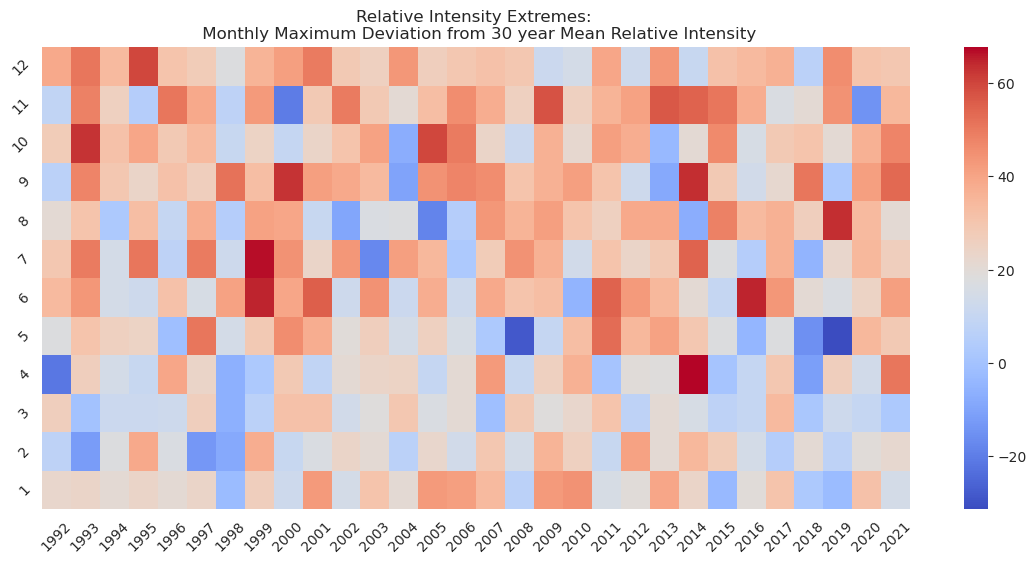

In [109]:
gdf["Year"] = gdf.start.apply(lambda x: x.year)
gdf["Month"] = gdf.start.apply(lambda x: x.month)
pt = gdf.pivot_table(index="Month",columns="Year",values="rintensity_dev", aggfunc="max").fillna(0)

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(pt, annot=False, ax=ax, cmap='coolwarm')

ax.invert_yaxis()
ax.set_title('Relative Intensity Extremes: \n Monthly Maximum Deviation from 30 year Mean Relative Intensity')
ax.set(xlabel=None, ylabel=None)
plt.xticks(rotation=45)
plt.yticks(rotation=45)

#### Geographic Heatmaps:

View AR event location "hotspots". Create a hexgrid heatmap with in geographic space using both whole AR event polygon centroids and clipped AK coastline midpoints.

In [230]:
#data prep
ak_3338 = gpd.read_file(ak_shp)
gdf_3338 = gdf_4326.to_crs(ak_3338.crs)
#add count of 1 to each event to use in agg function later
gdf_3338['count'] = 1

In [231]:
#create simple line to represent southern AK coast
#starting with a coordinates dataframe
lonlats = {173:52.5, 178.5:51.5, -176:52, -173:52, -164:54, -153:57, -151:59, -147:60, -141:60, -137:58, -133:55}
df = pd.DataFrame.from_dict(lonlats, orient='index').reset_index().rename(columns={'index':'X', 0:'Y'})
#zip the coordinates into a point object and convert to gdf
geometry = [Point(xy) for xy in zip(df.X, df.Y)]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)
geo_df['id'] = 'ak_coast'
#use the points in order to create a linestring
geo_df2 = geo_df.groupby('id')['geometry'].apply(lambda x: LineString(x.tolist()))
ak_coast = gpd.GeoDataFrame(geo_df2, geometry='geometry', crs=gdf_4326.crs)
ak_coast = ak_coast.to_crs(ak_3338.crs)
#plot
# fig, ax = plt.subplots(figsize=(10, 6))
# ak_3338.geometry.boundary.plot(color='black', ax=ax)
# ak_coast.plot(color='red', ax=ax)

In [232]:
#perform overlay analysis to get just parts of AR polygons intersecting coast
gdf_ak_int = ak_coast.overlay(gdf_3338, how='intersection', keep_geom_type=True)
#explode into individual line segments (to account for ARs with multiple polygon parts intersecting coast)
gdf_ak_int = gdf_ak_int.explode(index_parts=False)
#get midpoints of each linestring and reset geometry
gdf_ak_int['midpoints'] = gdf_ak_int.geometry.apply(lambda x: x.line_interpolate_point(.5, normalized=True))
gdf_ak_int = gdf_ak_int.set_geometry(gdf_ak_int['midpoints'])


Text(0.5, 1.08, 'AR Event #: 1729\n\nStart: 2020-11-26T06:00:00.000000000\nEnd: 2020-12-01T00:00:00.000000000\n\nEvent Centroid vs. Coastal Intersection Midpoints')

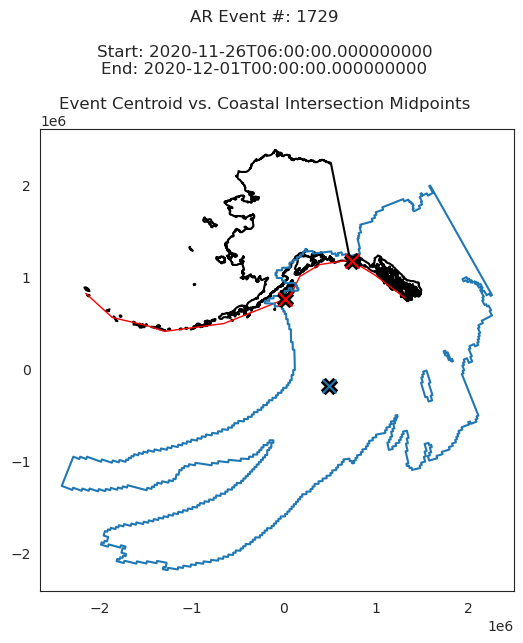

In [233]:
#view Haines 2020 AR event example
#plot whole AR centroid vs. coastal AR midpoints

#Haines 2020 AR event number
e = 1729
d1 = str(gdf_3338[gdf_3338['event_id']==e]['start'].values[0])
d2 = str(gdf_3338[gdf_3338['event_id']==e]['end'].values[0])

fig, ax = plt.subplots(figsize=(10, 6))

ak_3338.geometry.boundary.plot(ax=ax, color='black', zorder=1)
ak_coast.plot(color='red', linewidth=1, ax=ax, zorder=1.5)

gdf_3338.loc[gdf_3338['event_id']==e].boundary.plot(ax=ax, zorder=2)
gdf_3338.loc[gdf_3338['event_id']==e,'geometry'].centroid.plot(ax=ax, color='black', markersize=125, marker='X', zorder=3)
gdf_3338.loc[gdf_3338['event_id']==e,'geometry'].centroid.plot(ax=ax, markersize=100, marker='x', zorder=4)

gdf_ak_int.loc[gdf_ak_int['event_id']==e].midpoints.plot(ax=ax, color='red', zorder=5)
gdf_ak_int.loc[gdf_ak_int['event_id']==e].midpoints.plot(ax=ax, color='black', markersize=125, marker='X', zorder=6)
gdf_ak_int.loc[gdf_ak_int['event_id']==e].midpoints.plot(ax=ax, color='red', markersize=100, marker='x', zorder=7)

fig.suptitle(("AR Event #: " + str(e) + "\n\nStart: " + d1 + "\nEnd: " + d2 + "\n\nEvent Centroid vs. Coastal Intersection Midpoints"), y=1.08)


In [112]:
#function to create a hexagon grid

def create_hexgrid(feature, side_length, crs):
    # get extent
    min_x, min_y, max_x, max_y = feature.total_bounds

    # create empty list to hold individual cells that will make up the grid
    cells_list = []

    # Set horizontal displacement that will define column positions with specified side length (based on normal hexagon)
    x_step = 1.5 * side_length

    # Set vertical displacement that will define row positions with specified side length (based on normal hexagon)
    # This is the distance between the centers of two hexagons stacked on top of each other (vertically)
    y_step = math.sqrt(3) * side_length

    # Get apothem (distance between center and midpoint of a side, based on normal hexagon)
    apothem = (math.sqrt(3) * side_length / 2)

    # Set column number
    column_number = 0

    # Create and iterate through list of x values that will define column positions with vertical displacement
    for x in np.arange(min_x, max_x + x_step, x_step):

        # Create and iterate through list of y values that will define column positions with horizontal displacement
        for y in np.arange(min_y, max_y + y_step, y_step):

            # Create hexagon with specified side length
            hexagon = [[x + math.cos(math.radians(angle)) * side_length, y + math.sin(math.radians(angle)) * side_length] for angle in range(0, 360, 60)]

            # Append hexagon to list
            cells_list.append(Polygon(hexagon))

        # Check if column number is even
        if column_number % 2 == 0:

            # If even, expand minimum and maximum y values by apothem value to vertically displace next row
            # Expand values so as to not miss any features near the feature extent
            min_y -= apothem
            max_y += apothem

        # Else, odd
        else:

            # Revert minimum and maximum y values back to original
            min_y += apothem
            max_y -= apothem

        # Increase column number by 1
        column_number += 1


    # Create grid from list of cells
    grid = gpd.GeoDataFrame(cells_list, columns = ['geometry'], crs = crs)

    # Create a column that assigns each grid a number
    grid["Grid_ID"] = np.arange(len(grid))

    # Return grid
    return grid

In [251]:
#function to group properties by hexgrid cells and aggregate values for plotting
#assumes that full gdf geometry is already reset to centroid or midpoint 

def agg_by_hexgrid_cells(hexgrid, hexid, gdf, prop, agg):
    #hexgrid = gdf of hexgrid used to join centroids/midpoints
    #hexid = unique cell id field in hexgrid gdf (as string, eg "hex_id")
    #gdf = AR events gdf with geometry set to centroid (if polygons) or midpoints (if lines)
    #prop = gdf column with property to aggregate (as string, eg "length")
    #agg = function to use in aggregation (as string, eg "mean")

    #spatial joins to hexgrid (ar centroid counts)
    hexjoin = gpd.sjoin(gdf, hexgrid, how='inner', predicate='intersects')
    #groupby and apply function
    hexjoin_ = hexjoin.groupby(hexid).agg({prop:agg})
    # merge back to grid and fill 0s
    hexgrid_ = hexgrid.merge(hexjoin_, on = hexid, how = "left")
    hexgrid_[prop] = hexgrid_[prop].fillna(0)
    # convert result to integer
    hexgrid_[prop] = hexgrid_[prop].astype(int)

    return hexgrid_

In [252]:
#reset gdf_3338 geometries to centroid and create new gdf (coastal intersection midpoint is already set as geometry)
gdf_3338_c = gdf_3338.copy()
gdf_3338_c['geom'] = gdf_3338_c.geometry.centroid
gdf_3338_c = gdf_3338_c.set_geometry('geom')

#create hexgrid and aggregate various properties
hexgrid = create_hexgrid(gdf_3338, 30000, gdf_3338.crs)

centroid_counts = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_3338_c, 'count', 'sum')
centroid_mean_intensity = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_3338_c, 'rintensity', 'mean')
centroid_max_intensity = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_3338_c, 'rintensity', 'max')
centroid_max_intensity_deviation = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_3338_c, 'rintensity_dev', 'max')


coast_counts = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_ak_int, 'count', 'sum')
coast_mean_intensity = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_ak_int, 'rintensity', 'mean')
coast_max_intensity = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_ak_int, 'rintensity', 'max')
coast_max_intensity_deviation = agg_by_hexgrid_cells(hexgrid, 'Grid_ID', gdf_ak_int, 'rintensity_dev', 'max')



# #spatial joins to hexgrid (ar centroid counts)
# hexjoin = gpd.sjoin(gdf_3338_c, hexgrid, how='inner', predicate='intersects')
# #groupby and sum centroids
# hexjoin['c_count'] = 1
# hexjoin_c = hexjoin.groupby('Grid_ID').agg({'c_count':'sum'})
# # merge back to grid and fill 0s
# hexgrid_c = hexgrid.merge(hexjoin_c, on = 'Grid_ID', how = "left")
# hexgrid_c['c_count'] = hexgrid_c['c_count'].fillna(0)
# # convert count to integer
# hexgrid_c['c_count'] = hexgrid_c['c_count'].astype(int)


# #spatial joins to hexgrid (coast midpoint counts)
# hexjoin_ = gpd.sjoin(gdf_ak_int, hexgrid, how='inner', predicate='intersects')
# #groupby and sum centroids
# hexjoin_['c_count'] = 1
# hexjoin_c_ = hexjoin_.groupby('Grid_ID').agg({'c_count':'sum'})
# # merge back to grid and fill 0s
# hexgrid_c_ = hexgrid.merge(hexjoin_c_, on = 'Grid_ID', how = "left")
# hexgrid_c_['c_count'] = hexgrid_c_['c_count'].fillna(0)
# # convert count to integer
# hexgrid_c_['c_count'] = hexgrid_c_['c_count'].astype(int)


# #spatial joins to hexgrid (coast midpoint mean intensity)
# hexjoin_i = gpd.sjoin(gdf_ak_int, hexgrid, how='inner', predicate='intersects')
# #groupby and avg relative intensity
# hexjoin_i_ = hexjoin_i.groupby('Grid_ID').agg({'rintensity':'mean'})
# # merge back to grid and fill 0s
# hexgrid_i_ = hexgrid.merge(hexjoin_i_, on = 'Grid_ID', how = "left")
# hexgrid_i_['rintensity'] = hexgrid_i_['rintensity'].fillna(0)



(-1500000.0, 2250000.0)

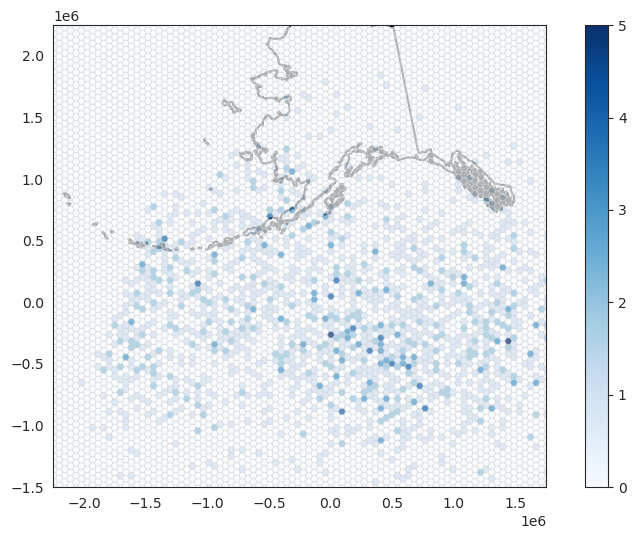

In [253]:
fig, ax = plt.subplots(figsize=(10, 6))

ak_3338.geometry.boundary.plot(ax=ax, color='black', zorder=1)
centroid_counts.plot(ax=ax, column="count", cmap="Blues", edgecolor='lightgray', linewidth = 0.5, alpha = 0.70, legend = True)

ax.set_xlim([-2250000, 1750000])
ax.set_ylim([-1500000, 2250000])

(-1500000.0, 2250000.0)

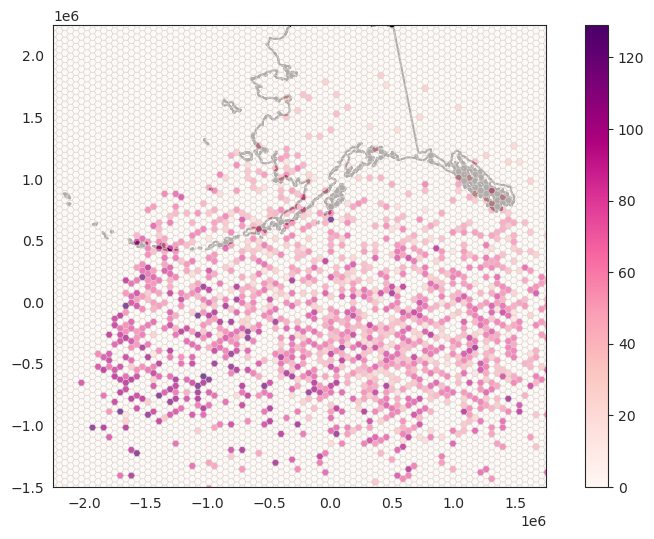

In [254]:
fig, ax = plt.subplots(figsize=(10, 6))

ak_3338.geometry.boundary.plot(ax=ax, color='black', zorder=1)
centroid_mean_intensity.plot(ax=ax, column="rintensity", cmap="RdPu", edgecolor='lightgray', linewidth = 0.5, alpha = 0.70, legend = True)

ax.set_xlim([-2250000, 1750000])
ax.set_ylim([-1500000, 2250000])

(-1500000.0, 2250000.0)

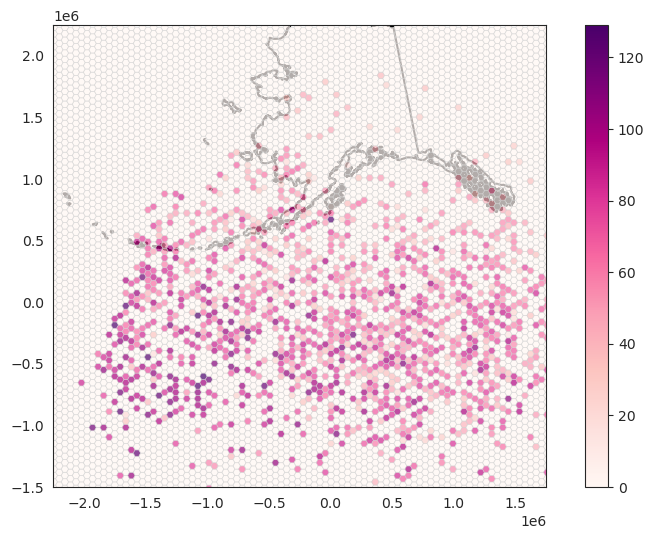

In [255]:
fig, ax = plt.subplots(figsize=(10, 6))

ak_3338.geometry.boundary.plot(ax=ax, color='black', zorder=1)
centroid_max_intensity.plot(ax=ax, column="rintensity", cmap="RdPu", edgecolor='lightgray', linewidth = 0.5, alpha = 0.70, legend = True)

ax.set_xlim([-2250000, 1750000])
ax.set_ylim([-1500000, 2250000])

(-1500000.0, 2250000.0)

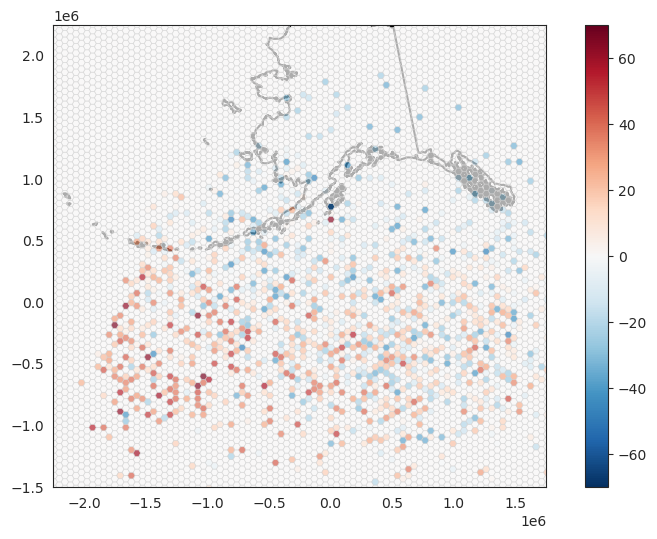

In [268]:
fig, ax = plt.subplots(figsize=(10, 6))

ak_3338.geometry.boundary.plot(ax=ax, color='black', zorder=1)
centroid_max_intensity_deviation.plot(ax=ax, column="rintensity_dev", cmap="RdBu_r", edgecolor='lightgray', linewidth = 0.5, alpha = 0.70, legend = True, vmin = -70,
                             vmax = 70)

ax.set_xlim([-2250000, 1750000])
ax.set_ylim([-1500000, 2250000])

(0.0, 2250000.0)

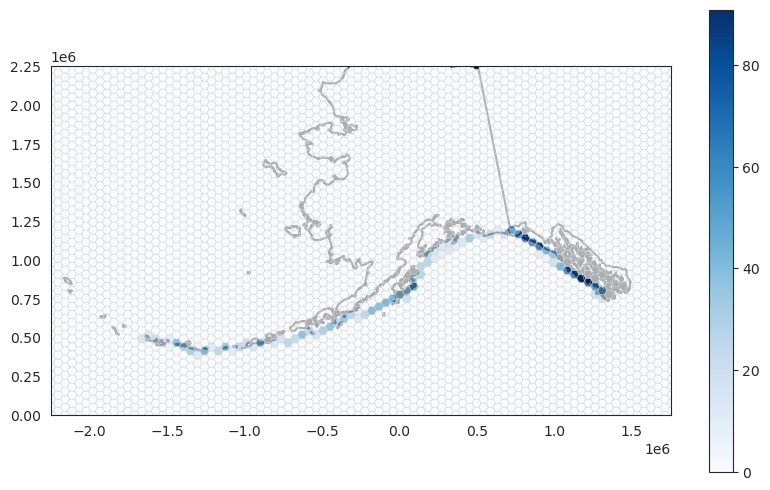

In [257]:
fig, ax = plt.subplots(figsize=(10, 6))

ak_3338.geometry.boundary.plot(ax=ax, color='black', zorder=1)
coast_counts.plot(ax=ax, column="count", cmap="Blues", edgecolor='lightgray', linewidth = 0.5, alpha = 0.70, legend = True)

ax.set_xlim([-2250000, 1750000])
ax.set_ylim([0, 2250000])

(0.0, 2250000.0)

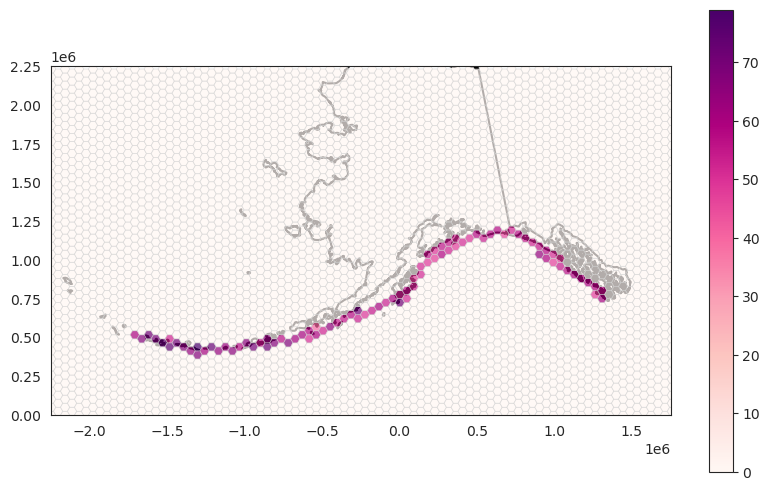

In [258]:
fig, ax = plt.subplots(figsize=(10, 6))

ak_3338.geometry.boundary.plot(ax=ax, color='black', zorder=1)
coast_mean_intensity.plot(ax=ax, column="rintensity", cmap="RdPu", edgecolor='lightgray', linewidth = 0.5, alpha = 0.70, legend = True)

ax.set_xlim([-2250000, 1750000])
ax.set_ylim([0, 2250000])

(0.0, 2250000.0)

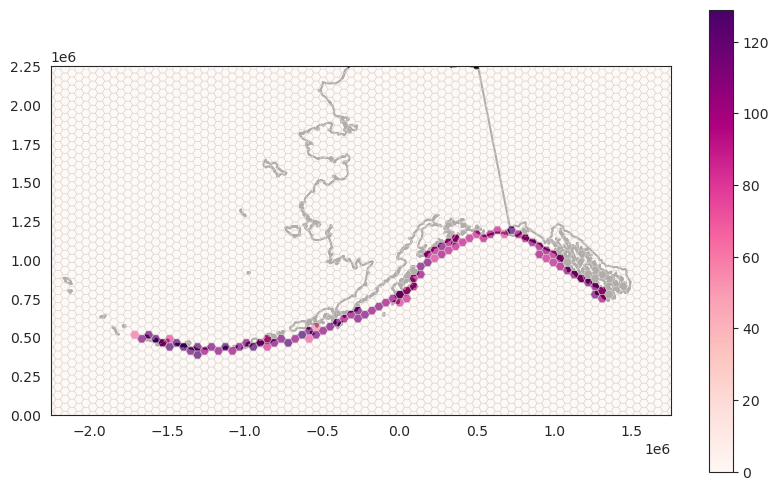

In [259]:
fig, ax = plt.subplots(figsize=(10, 6))

ak_3338.geometry.boundary.plot(ax=ax, color='black', zorder=1)
coast_max_intensity.plot(ax=ax, column="rintensity", cmap="RdPu", edgecolor='lightgray', linewidth = 0.5, alpha = 0.70, legend = True)

ax.set_xlim([-2250000, 1750000])
ax.set_ylim([0, 2250000])

(0.0, 2250000.0)

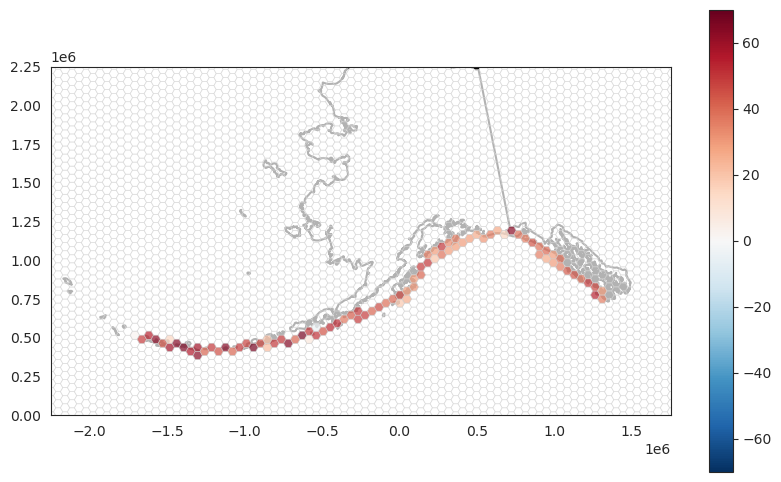

In [266]:
fig, ax = plt.subplots(figsize=(10, 6))

ak_3338.geometry.boundary.plot(ax=ax, color='black', zorder=1)

hexgrid.plot(ax=ax, color='white', edgecolor='lightgray', linewidth = 0.5, alpha = 0.70)
coast_max_intensity_deviation['rintensity_dev'].replace(0, np.nan, inplace=True)
coast_max_intensity_deviation.plot(ax=ax, column="rintensity_dev", cmap="RdBu_r", edgecolor='lightgray', linewidth = 0.5, alpha = 0.70, legend = True, vmin = -70,
                             vmax = 70)

ax.set_xlim([-2250000, 1750000])
ax.set_ylim([0, 2250000])